In [1]:
import typhon_model
# from architecture_loader import ArchitectureLoader
import torch.nn as nn
import torch
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
import random

In [2]:
MODEL_PATH = './results_atari/20221231_AE6_s2_0_3/models/train_model_p.pth'     # AE6 s2
# MODEL_PATH = './results_atari/20230102_AE6_s2b_2_0/models/train_model_p.pth'    # AE6 s2b
# MODEL_PATH = './results_atari/20221230_AE6_all0_1/models/train_model_p.pth'     # AE6
# MODEL_PATH = './results_atari/20230104_VAE6_bcemse5_2/models/train_model_p.pth' # VAE6
IS_VAE = False

In [3]:
envs = ['DemonAttack-v5', 'FishingDerby-v5', 'Frostbite-v5', 'Kangaroo-v5', 'NameThisGame-v5', 'Phoenix-v5', 'Qbert-v5', 'Seaquest-v5', 'SpaceInvaders-v5', 'TimePilot-v5'],
ENV_NAME = 'DemonAttack-v5'

INPUT_FOLDER = f'/home/jonas/Desktop/SmallDataAtari/{ENV_NAME}/val/'

FILENAME = random.choice(os.listdir(INPUT_FOLDER)) # Choose random file
INPUT_PATH = INPUT_FOLDER + FILENAME
print(INPUT_PATH)

/home/jonas/Desktop/SmallDataAtari/DemonAttack-v5/val/5035.npy


In [24]:
def load_npy(path):
    ary = np.load(path)
    # Move color channel in front
    ary = ary.transpose(2, 0, 1)
    # print(ary.shape)
    # Normalize
    ary = np.divide(ary, 255)
    ary.shape = (1, *ary.shape)
    # Convert to tenso
    img = torch.from_numpy(ary).float()
    # Remove mode
    print(img.shape)
    mode = img.mode(dim=0)[0]
    print(mode.shape)
    # Expand to match size
    mode_tensor = torch.tensor(mode)
#     mode_tensor = torch.tensor([mode[0], mode[1], mode[2]]).expand(img.shape[2], img.shape[3], 3).transpose(1, 2).transpose(0, 1)
    # Remove mode from inputs (but NOT from labels)
    #  We keep mode in the label to have values in [0,1] and be able to use BCE. In any case, the mode can be learned by the
    #  dms independently from the input
    img -= mode_tensor
    img = torch.abs(img)
    return img

def plottable_image(tensor):
    return (tensor[0].cpu().detach().numpy().transpose(1, 2, 0) * 255).astype('uint8')

In [25]:
inp = load_npy(INPUT_PATH)

torch.Size([1, 3, 210, 160])
torch.Size([3, 210, 160])


/tmp/ipykernel_13501/28558862.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mode_tensor = torch.tensor(mode)


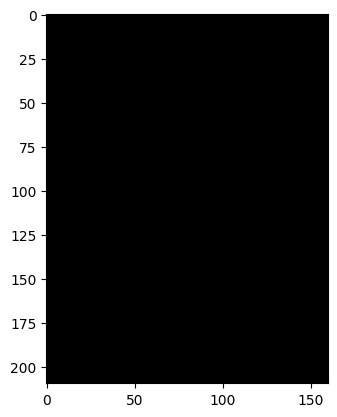

In [26]:
plt.imshow(plottable_image(inp))

In [6]:
# Load model
model_dict = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
model = typhon_model.TyphonModel.from_state_dict(model_dict)

In [7]:
def compute_losses(model, input_tensor, env, mu_var):
    if mu_var:
        output, mu, logvar = model.forward(input_tensor, env)
        kld = (-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())).detach().numpy().item()
    else:
        output = model.forward(input_tensor, env)
        kld = 0
    mse = torch.nn.MSELoss()(output, input_tensor).detach().numpy().item()
    bce = torch.nn.BCELoss()(output, input_tensor).detach().numpy().item()
    return mse, bce, kld

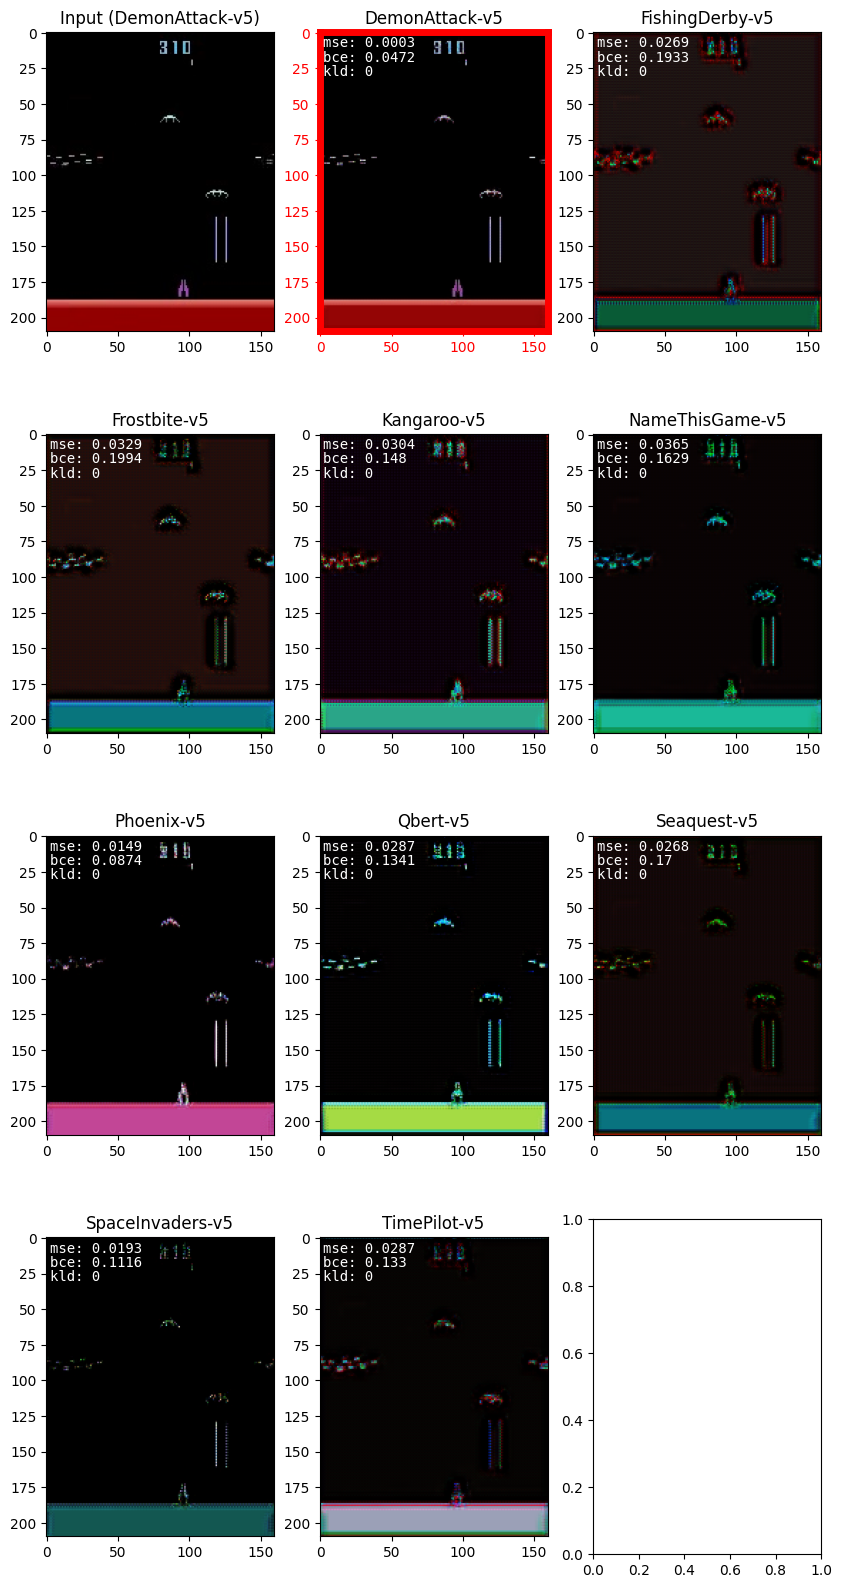

In [8]:
_, axs = plt.subplots(4,3, figsize=(10, 20)) 

axs[0,0].imshow(plottable_image(inp))
axs[0,0].set_title(f'Input ({ENV_NAME})')

for env_name, ax in zip(model.dsets_names, axs.flatten()[1:]):
    if IS_VAE:
        ax.imshow(plottable_image(model.forward(inp, env_name)[0])) # 'forward' returns 3 values for VAEs
    else:
        ax.imshow(plottable_image(model.forward(inp, env_name)))
    ax.set_title(env_name)
    # Add losses
    mse, bce, kld = compute_losses(model, inp, env_name, IS_VAE)
    ax.text(2, 10, f'mse: {round(mse, 4)}', color='white', fontname='monospace')
    ax.text(2, 20, f'bce: {round(bce, 4)}', color='white', fontname='monospace')
    ax.text(2, 30, f'kld: {round(kld, 4)}', color='white', fontname='monospace')
    # Highlight 'correct' dms
    if env_name == ENV_NAME:
        ax.tick_params(color='red', labelcolor='red')
        for spine in ax.spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(5)